## Sarcasm Detection using Natural Language Processing - LSTM

## Prework for the project

Installing Tensorflow 2.0

In [ ]:
!!pip uninstall tensorflow
!pip install tensorflow==2.0.0

Mounting the drive and Getting required files

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [8]:
project_path = '/content/drive/My Drive/GL/NLP/week6/'

Importing the libraries

In [49]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, LSTM
from keras.models import Model, Sequential

## Reading and Exploring the data

Reading the data and getting some insight about the data

In [19]:
df = pd.read_json(project_path + 'Sarcasm_Headlines_Dataset.json', lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [20]:
df.shape

(26709, 3)

In [21]:
df.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

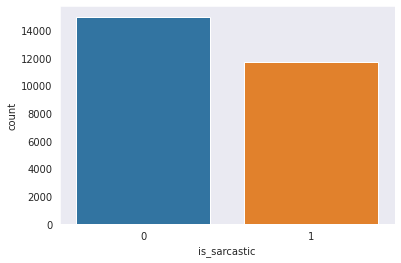

In [22]:
import seaborn as sns
sns.set_style("dark")
sns.countplot(df['is_sarcastic'])

Droping 'article_link' column from dataset

In [23]:
df = df.drop('article_link', axis = 1)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


Getting length of each line and finding the maximum length

In [24]:
df['len'] = df['headline'].apply(lambda x: len(x.split(" ")))
df.head()

,headline,is_sarcastic,len
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


In [28]:
df['len'].max()

39

In [29]:
df['len'].min()

2

From above information it appears that maximum lenght of the line is 39 and minimum lenght is 2

Setting parameters for the model

In [30]:
max_features = 10000
maxlen = 25 #Keeping 25 by considering the length of all the sentences
embedding_size = 200

Applying Tokenizer for headline column

In [31]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df['headline']))

Defining X and Y for the model

In [32]:
X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(df['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 26709
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  307  678 3336 2297   47  381 2575    5 2576 8433]
Number of Labels:  26709
0


Getting the Vocabulary size

In [34]:
vocab = tokenizer.word_index
vocab_size = len(vocab)
vocab_size

29656

## Word Embeddings

Using Glove embeddings

In [36]:
glove_file = project_path + "glove.6B.zip"

In [37]:
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

Getting Word embeddedings using above glove embedding file

In [40]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    #print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    #print(embd)
    embeddings[word] = embd

In [44]:
all_embs = np.stack(embeddings.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


Creating Weight Matrix for words

In [46]:
nb_words = min(max_features, len(vocab))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [47]:
embedding_matrix

array([[ 0.71007783, -0.41454493,  0.25462217, ...,  0.39295596,
        -0.173456  , -0.53908619],
       [ 0.57345998,  0.54170001, -0.23477   , ...,  0.54417998,
        -0.23069   ,  0.34946999],
       [ 0.052924  ,  0.25426999,  0.31353   , ..., -0.086254  ,
        -0.41916999,  0.46496001],
       ...,
       [-0.064469  , -0.35021001,  0.059525  , ...,  0.77337998,
         0.43211001,  0.60882998],
       [-0.37301001,  0.93186998,  0.32776001, ..., -0.13988   ,
         0.1785    , -0.51409   ],
       [ 0.44672999, -0.50958002, -0.11211   , ...,  0.084711  ,
         0.17919999, -0.15125   ]])

Creating and Compiling the model

In [50]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         336896    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                10280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)               

#Fitting the model

In [58]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 1) 

In [59]:
batch_size = 100
epochs = 5
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (x_test,y_test))

Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 38s 2ms/step - loss: 0.0878 - accuracy: 0.9789 - val_loss: 0.0739 - val_accuracy: 0.9802
Epoch 2/5
21367/21367 [==============================] - 38s 2ms/step - loss: 0.0374 - accuracy: 0.9916 - val_loss: 0.1098 - val_accuracy: 0.9723
Epoch 3/5
21367/21367 [==============================] - 38s 2ms/step - loss: 0.0204 - accuracy: 0.9956 - val_loss: 0.1350 - val_accuracy: 0.9730
Epoch 4/5
21367/21367 [==============================] - 38s 2ms/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.2005 - val_accuracy: 0.9639
Epoch 5/5
21367/21367 [==============================] - 38s 2ms/step - loss: 0.0150 - accuracy: 0.9956 - val_loss: 0.1697 - val_accuracy: 0.9708


Accuracy of the Model

In [60]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

21367/21367 [==============================] - 8s 382us/step
Accuracy of the model on Training Data is -  99.81747269630432
5342/5342 [==============================] - 2s 408us/step
Accuracy of the model on Testing Data is -  97.07974791526794


Above results shows validation accuracy of around 97%